# Henry Ezeanowi - 8900446

# Lab 10

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

### Find 3 classes with the highest number of images

In [3]:
# Get dataset

train_dir = pathlib.Path("C:/Users/HENRY CHU/Documents/dataset/train")

test_dir = pathlib.Path("C:/Users/HENRY CHU/Documents/dataset/test")
valid_dir = pathlib.Path("C:/Users/HENRY CHU/Documents/dataset/valid")
train_dir

WindowsPath('C:/Users/HENRY CHU/Documents/dataset/train')

Dictionary to store image count for each class

In [4]:
image_count = {}

Loop through sub directories and update the count for each class

In [5]:
for species in os.listdir(train_dir):
    species_path = os.path.join(train_dir, species)
    if os.path.isdir(species_path):
        image_count[species] = len(os.listdir(species_path))

# sort the dictionary to list 3 top class
top_3_class = sorted(image_count, key=image_count.get, reverse=True)[:3]

print('Top 3 class with highest number of images:', top_3_class)

Top 3 class with highest number of images: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [6]:
top_3_class = ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']

def remove_dir(dir_path):
    for entry in os.scandir(dir_path):
        if entry.is_file():
            os.remove(entry.path)
        elif entry.is_dir() and entry.name not in top_3_class:
            # recursively call the function to remove the files inside
            remove_dir(entry.path)
            # remove empty folder after removing files
            os.rmdir(entry.path)

# Paths to the directories
train_path = "C:/Users/HENRY CHU/Documents/dataset/train"
test_path = "C:/Users/HENRY CHU/Documents/dataset/test"
validation_path = "C:/Users/HENRY CHU/Documents/dataset/valid"

# Call the function for three folders
remove_dir(train_path)
remove_dir(test_path)
remove_dir(validation_path)

### Use data-augmentation to increase the number of training images.

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(train_path, image_size=(224,224), batch_size=32)
validation_data = image_dataset_from_directory(validation_path, image_size=(224,224), batch_size=32)
test_data = image_dataset_from_directory(test_path, image_size=(224,224), batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


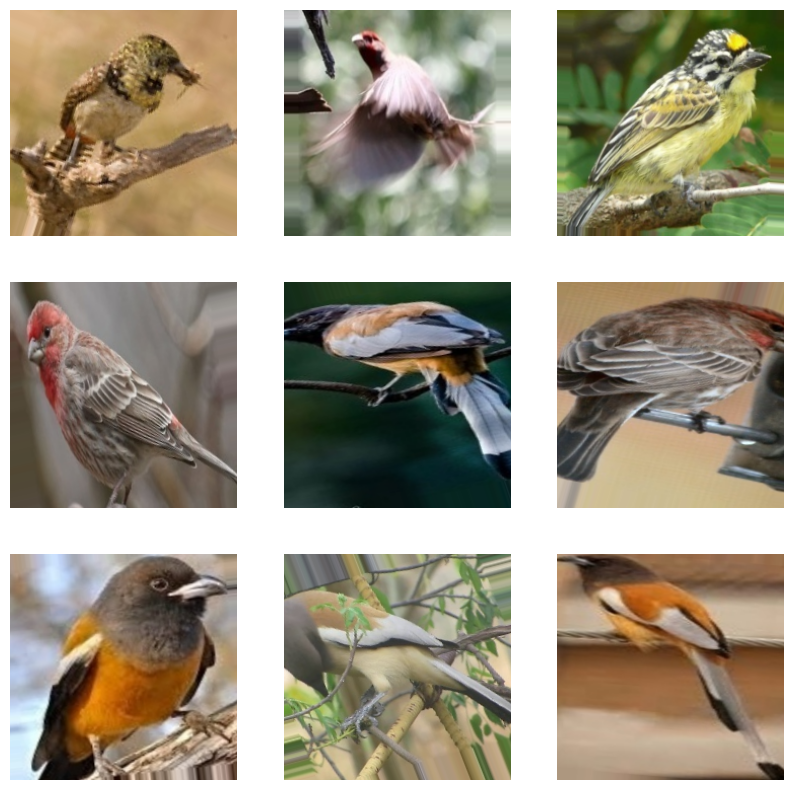

In [8]:
#from keras.preprocessing.image import ImageDataGenerator

augmented_data = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_data_generator = ImageDataGenerator(rescale = 1.0/255)

train_generator = augmented_data.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = augmented_data.flow_from_directory(
    validation_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# display some augmented training images

# get images and labels from train_generator
images, _ = next(train_generator)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()

### Fine-Tune VGG16 (pre-trained on imagenet), to classify the 3 classes

In [9]:
# load pre-trained VGG16 model from imagenet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)


predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [13]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 220s 9s/step - loss: 1.6317 - accuracy: 0.8159 - val_loss: 8.6758e-04 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 226s 9s/step - loss: 0.3633 - accuracy: 0.9503 - val_loss: 0.2380 - val_accuracy: 0.9333
Epoch 3/10
24/24 [==============================] - 237s 10s/step - loss: 0.1295 - accuracy: 0.9758 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 233s 10s/step - loss: 0.1598 - accuracy: 0.9704 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 233s 10s/step - loss: 0.0945 - accuracy: 0.9839 - val_loss: 1.5671e-05 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 222s 9s/step - loss: 0.0952 - accuracy: 0.9745 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 228s 9s/step - loss: 0.1576 - accuracy: 0.9651 - val_loss: 0.0145 - val_accuracy: 1.0000
Ep

### Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly.

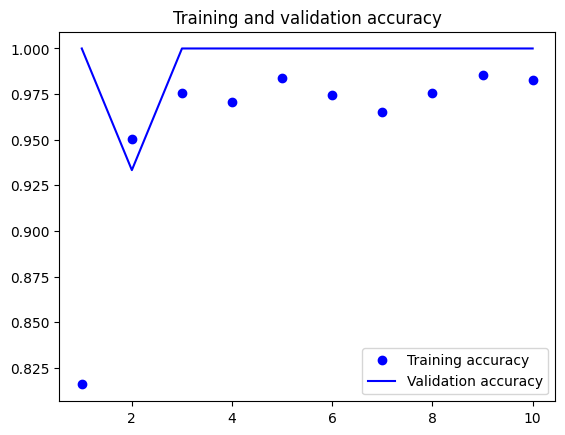

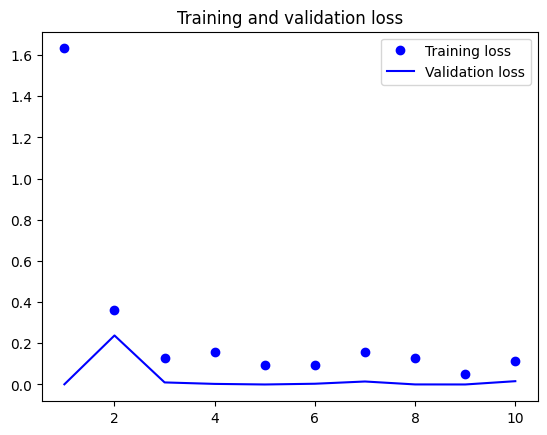

In [14]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 5s 5s/step - loss: 1.6229e-04 - accuracy: 1.0000
Test accuracy: 1.000


In [16]:
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_class)

print(classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys()))

1/1 [==============================] - 6s 6s/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.40      0.40      0.40         5
     HOUSE FINCH       0.20      0.20      0.20         5
    RUFOUS TREPE       0.00      0.00      0.00         5

        accuracy                           0.20        15
       macro avg       0.20      0.20      0.20        15
    weighted avg       0.20      0.20      0.20        15



1/1 [==============================] - 5s 5s/step


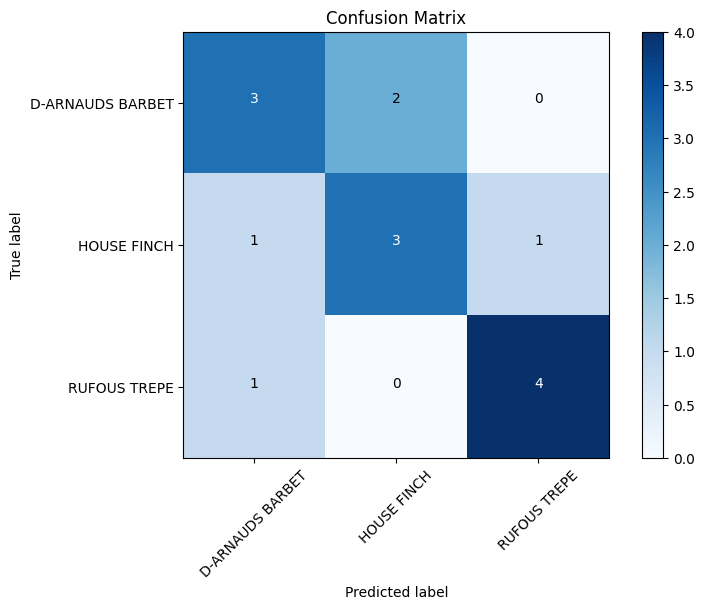

Classification Report:
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.60      0.60      0.60         5
     HOUSE FINCH       0.60      0.60      0.60         5
    RUFOUS TREPE       0.80      0.80      0.80         5

        accuracy                           0.67        15
       macro avg       0.67      0.67      0.67        15
    weighted avg       0.67      0.67      0.67        15



In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Replace these with your actual model predictions and true labels
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# precision, recall, and F1-score
report = classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys())

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=validation_generator.class_indices.keys(), title='Confusion Matrix')

# Display precision, recall, and F1-score
print("Classification Report:")
print(report)

AUC for D-ARNAUDS BARBET: 0.5808874458874459
AUC for HOUSE FINCH: 0.561007326007326
AUC for RUFOUS TREPE: 0.6494444444444445


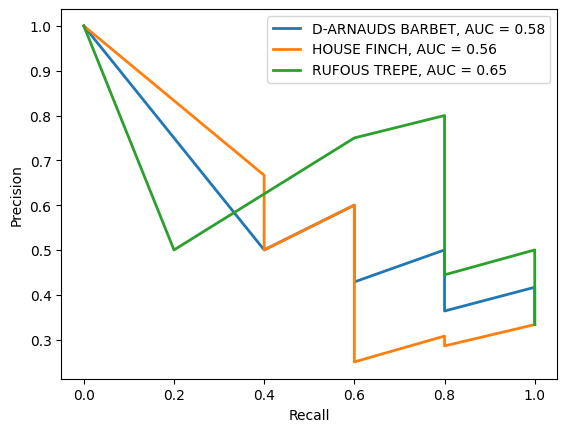

In [18]:
# convert true labels to one-hot encoding for multi-class
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()